(500, 4)
(10,)


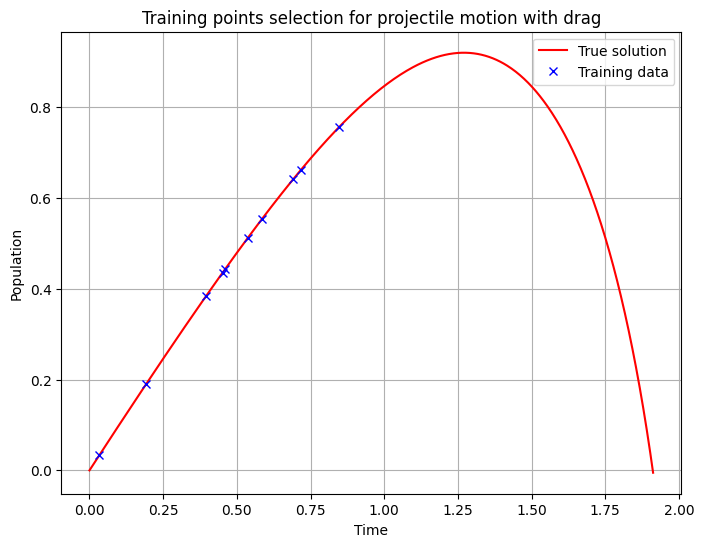

In [9]:
#Solving projectile motion with drag so need to first solve using odeint
import numpy as np
import torch

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE
def proj_motion(y,t):
    sx = y[0]
    sy = y[1]
    vx = y[2]
    vy = y[3]
    mu = 1
    g = 9.8

    dsxdt = vx
    dsydt = vy
    dvxdt = -mu * np.sqrt(vx**2 + vy**2)*vx
    dvydt = -mu * np.sqrt(vx**2 + vy**2)*vy - g

    return [dsxdt, dsydt, dvxdt, dvydt]

# Initial condition
y0 = [0,0,10,10]
mu = 1
g = 9.8

# Time points
t = np.linspace(0, 0.85,500)

# Solve the ODE
solution = odeint(proj_motion, y0, t)
print(solution.shape)

sx = solution[:,0]
sy = solution[:,1]
vx = solution[:,2]
vy = solution[:,3]

# Generate training data (based on noisy data or the true solution)
# training_t, training_y(prey, predator) noisy with gaussian, true_solution
pool = range(0,100)
idx = np.random.choice(pool, 10, replace=True)
training_t = t[idx]
sx_train = sx[idx]
sy_train = sy[idx]
vx_train = vx[idx]
vy_train = vy[idx]
print(sx_train.shape)
# reshape to (100, 1)
training_t = training_t[:, np.newaxis]
true_data = solution[idx]
noise = np.random.normal(-0.1, 0.1, true_data.shape)
training_y = true_data + noise

# plot the training datas and the true solution
plt.figure(figsize=(8, 6))
plt.plot(sx, sy, 'r-', label='True solution')
plt.plot(sx_train, sy_train, 'bx', label='Training data')
plt.title('Training points selection for projectile motion with drag')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#Make neural network
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the PINN model
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.dense1 = nn.Linear(1, 256)  # Input: time
        self.dense2 = nn.Linear(256, 256)
        self.dense3 = nn.Linear(256, 256)
        self.dense4 = nn.Linear(256, 256)
        self.dense5 = nn.Linear(256, 256)
        self.dense6 = nn.Linear(256, 4)  # Output: prey, predator

    def forward(self, t):
        t = t.view(-1,1)
        relu = torch.nn.ReLU()
        x = relu(self.dense1(t))
        x = relu(self.dense2(x))
        x = relu(self.dense3(x))
        x = relu(self.dense4(x))
        x = relu(self.dense5(x))
        sol = self.dense6(x)
        return sol
    
#Convert training data to np ndarray
if (type(training_t) is np.ndarray):
    training_t = torch.tensor(training_t, requires_grad=True, dtype=torch.float32)
    sx_train = torch.tensor(sx_train, requires_grad=True, dtype=torch.float32)
    sy_train = torch.tensor(sy_train, requires_grad=True, dtype=torch.float32)
    vx_train = torch.tensor(vx_train, requires_grad=True, dtype=torch.float32)
    vy_train = torch.tensor(vy_train, requires_grad=True, dtype=torch.float32)
    true_data = torch.tensor(true_data, dtype=torch.float32)


Epoch 0, Loss: 60.51392364501953
Data Loss: 60.51392364501953
Epoch 500, Loss: 0.0006227586418390274
Data Loss: 0.0006227586418390274
Epoch 1000, Loss: 0.0005259263562038541
Data Loss: 0.0005259263562038541
Epoch 1500, Loss: 0.00035835037124343216
Data Loss: 0.00035835037124343216


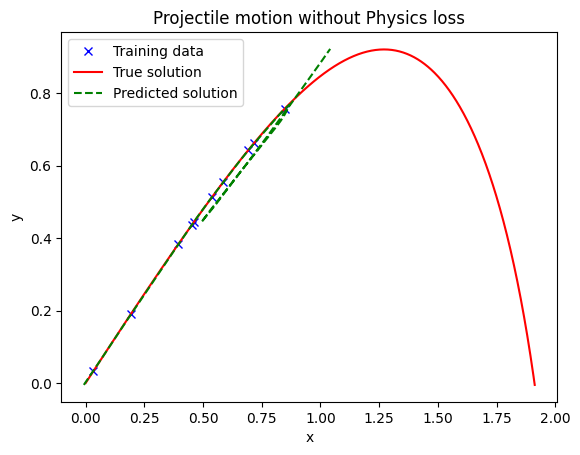

In [27]:
#Train the neural network without physics loss
model = PINNModel()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

t_phys = torch.linspace(0,0.85,100, requires_grad=True)

num_epochs = 2000  # Adjust as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions_data = model(training_t)
    predictions_data = predictions_data.requires_grad_()
    sx_pred = predictions_data[:,0]
    sy_pred = predictions_data[:,1]
    vx_pred = predictions_data[:,2]
    vy_pred = predictions_data[:,3]

    data_loss = torch.mean((sx_train - sx_pred)**2) + torch.mean((sy_train - sy_pred)**2) + torch.mean((vx_train - vx_pred)**2) + torch.mean((vy_train - vy_pred)**2)

    loss = data_loss # without physics loss

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        print(f'Data Loss: {data_loss}')

    loss.backward()

    optimizer.step()

test_t = np.linspace(0, 10, 1000)
test_t = test_t[:, np.newaxis]
test_t = torch.tensor(test_t, requires_grad=True, dtype=torch.float32)

results = model.forward(test_t)
sx_res = results[:,0]
sy_res = results[:,1]


plt.plot(sx_train.detach().numpy(),sy_train.detach().numpy(), 'bx', label='Training data')
plt.plot(sx, sy, 'r-', label='True solution')
plt.plot(sx_res.detach().numpy(), sy_res.detach().numpy(), 'g--', label='Predicted solution')
plt.title('Projectile motion without Physics loss')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('pset_nn_sol.jpeg', format = 'jpeg')
plt.show()

Epoch 0, Loss: 59.954872131347656
Physics Loss: 96.11466217041016
Data Loss: 59.94525909423828
Epoch 500, Loss: 0.004503561649471521
Physics Loss: 44.35845947265625
Data Loss: 6.77157731843181e-05
Epoch 1000, Loss: 0.002725343219935894
Physics Loss: 26.974342346191406
Data Loss: 2.790903818095103e-05
Epoch 1500, Loss: 0.0017223629401996732
Physics Loss: 16.319425582885742
Data Loss: 9.042050805874169e-05


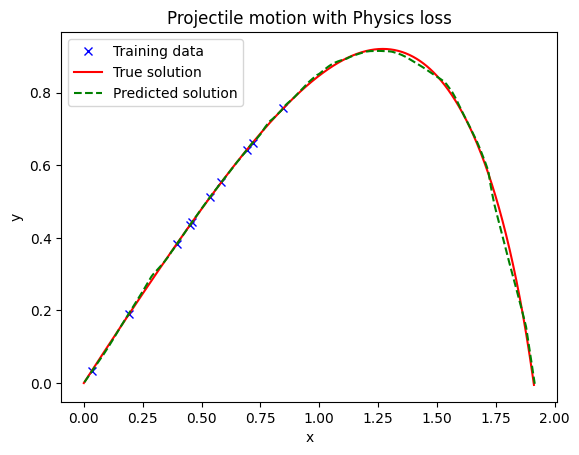

In [26]:
#Train the neural network with physics loss
model = PINNModel()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

t_phys = torch.linspace(0,0.85,100, requires_grad=True)

num_epochs = 2000  # Adjust as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions_data = model(training_t)
    predictions_data = predictions_data.requires_grad_()
    sx_pred = predictions_data[:,0]
    sy_pred = predictions_data[:,1]
    vx_pred = predictions_data[:,2]
    vy_pred = predictions_data[:,3]

    data_loss = torch.mean((sx_train - sx_pred)**2) + torch.mean((sy_train - sy_pred)**2) + torch.mean((vx_train - vx_pred)**2) + torch.mean((vy_train - vy_pred)**2)

    predictions_phys = model(t_phys)
    predictions_phys = predictions_phys.requires_grad_()
    sx_phys = predictions_phys[:,0]
    sy_phys = predictions_phys[:,1]
    vx_phys = predictions_phys[:,2]
    vy_phys = predictions_phys[:,3]

    #Do differentiation for physics loss
    dsxdt = torch.autograd.grad(sx_phys, t_phys, grad_outputs=torch.ones_like(sx_phys), create_graph=True)[0]
    dsydt = torch.autograd.grad(sy_phys, t_phys, grad_outputs=torch.ones_like(sy_phys), create_graph=True)[0]
    dvxdt = torch.autograd.grad(vx_phys, t_phys, grad_outputs=torch.ones_like(vx_phys), create_graph=True)[0]
    dvydt = torch.autograd.grad(vy_phys, t_phys, grad_outputs=torch.ones_like(vy_phys), create_graph=True)[0]
    
    phys_loss = torch.mean((dsxdt - vx_phys)**2) + torch.mean((dsydt - vy_phys)**2) + torch.mean((dvxdt + mu*torch.sqrt(vx_phys**2 + vy_phys**2)*vx_phys)**2) + torch.mean((dvydt + mu*torch.sqrt(vx_phys**2 + vy_phys**2)*vy_phys + g)**2)
    loss = data_loss + 0.0001*phys_loss

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        print(f'Physics Loss: {phys_loss}')
        print(f'Data Loss: {data_loss}')

    loss.backward()

    optimizer.step()

test_t = np.linspace(0, 0.85, 1000)
test_t = test_t[:, np.newaxis]
test_t = torch.tensor(test_t, requires_grad=True, dtype=torch.float32)

results = model.forward(test_t)
sx_res = results[:,0]
sy_res = results[:,1]


plt.plot(sx_train.detach().numpy(),sy_train.detach().numpy(), 'bx', label='Training data')
plt.plot(sx, sy, 'r-', label='True solution')
plt.plot(sx_res.detach().numpy(), sy_res.detach().numpy(), 'g--', label='Predicted solution')
plt.title('Projectile motion with Physics loss')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('pset_PINN_sol.jpeg', format = 'jpeg')
plt.show()